In [8]:
import tensorflow as tf
import numpy as np
import matplotlib.pyplot as plt
import skimage.transform
import time 

In [9]:
from IPython.display import SVG
from tensorflow.keras.datasets import cifar10
from tensorflow.keras.datasets import cifar100
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.callbacks import ReduceLROnPlateau, EarlyStopping
#from .Model import AttentionResNetCifar10

## cifar10 data

In [10]:
# Training parameters
batch_size = 32  # orig paper trained all networks with batch_size=128
epochs = 200
data_augmentation = True
num_classes = 10
subtract_pixel_mean = True
# Load the CIFAR10 data.
(x_train, y_train), (x_test, y_test) = cifar10.load_data()

In [8]:
x_train = x_train[:1000, :, :, :]
y_train = y_train[:1000]
x_test = x_test[:200, :, :, :]
y_test = y_test[:200]

# Input image dimensions.
input_shape = x_train.shape[1:]

x_train_224 = []
x_test_224 = []
for i in range(1000):
  temp = skimage.transform.resize(x_train[i,:,:,:], (224, 224), mode='constant')
  x_train_224.append(temp)
    
for i in range(200):
  temp = skimage.transform.resize(x_test[i,:,:,:], (224, 224), mode='constant')
  x_test_224.append(temp)

# Normalize data.
x_train = x_train_224.astype('float32') / 255
x_test = x_test_224.astype('float32') / 255

remove(x_train_224)
remove(x_test_224)

# If subtract pixel mean is enabled
if subtract_pixel_mean:
    x_train_mean = np.mean(x_train, axis=0)
    x_train -= x_train_mean
    x_test -= x_train_mean

print('x_train shape:', x_train.shape)
print(x_train.shape[0], 'train samples')
print(x_test.shape[0], 'test samples')
print('y_train shape:', y_train.shape)

# Convert class vectors to binary class matrices.
y_train = to_categorical(y_train, num_classes)
y_test = to_categorical(y_test, num_classes)

170500096/170498071 [==============================] - 60s 0us/step
x_train shape: (50000, 32, 32, 3)
50000 train samples
10000 test samples
y_train shape: (50000, 1)


In [48]:
(x_train, y_train), (x_test, y_test) = cifar10.load_data()

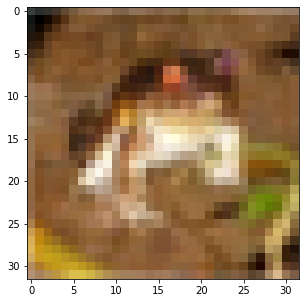

In [53]:
(x_train, y_train), (x_test, y_test) = cifar10.load_data()
fig = plt.figure(figsize=(5,5))

plt.imshow(x_train[0,:,:,:])
plt.show()

In [55]:
type(x_train)

numpy.ndarray

In [54]:
import skimage.transform
import time 

start = time.time()

# newImage = []
# newImage = skimage.transform.resize(x_train, (224, 224), mode='constant')
# fig = plt.figure(figsize=(5,5))

# plt.imshow(newImage)
# plt.show()

newImages = []
for i in range(10000):
  newImage = skimage.transform.resize(x_train[i,:,:,:], (224, 224), mode='constant')
  newImages.append(newImage)
    
end = time.time()
print("Time taken by above cell is {}.".format((end-start)/60))

Time taken by above cell is 2.6077450037002565.


In [ ]:
model.compile(loss='categorical_crossentropy',
              optimizer=Adam(learning_rate=lr_schedule(0)),
              metrics=['accuracy'])
model.summary()
print(model_type)



# Prepare model model saving directory.
save_dir = os.path.join(os.getcwd(), 'saved_models')
model_name = 'cifar10_%s_model.{epoch:03d}.h5' % model_type
if not os.path.isdir(save_dir):
    os.makedirs(save_dir)
filepath = os.path.join(save_dir, model_name)

# Prepare callbacks for model saving and for learning rate adjustment.
checkpoint = ModelCheckpoint(filepath=filepath,
                             monitor='val_acc',
                             verbose=1,
                             save_best_only=True)

lr_scheduler = LearningRateScheduler(lr_schedule)

lr_reducer = ReduceLROnPlateau(factor=np.sqrt(0.1),
                               cooldown=0,
                               patience=5,
                               min_lr=0.5e-6)

callbacks = [checkpoint, lr_reducer, lr_scheduler]

# Run training, with or without data augmentation.
if not data_augmentation:
    print('Not using data augmentation.')
    model.fit(x_train, y_train,
              batch_size=batch_size,
              epochs=epochs,
              validation_data=(x_test, y_test),
              shuffle=True,
              callbacks=callbacks)
else:
    print('Using real-time data augmentation.')
    # This will do preprocessing and realtime data augmentation:
    datagen = ImageDataGenerator(
        featurewise_center=False,
        samplewise_center=False,
        featurewise_std_normalization=False,
        samplewise_std_normalization=False,
        zca_whitening=False,
        zca_epsilon=1e-06,
        rotation_range=0,
        width_shift_range=0.1,
        height_shift_range=0.1,
        shear_range=0.,
        zoom_range=0.,
        channel_shift_range=0.,
        fill_mode='nearest',
        cval=0.,
        horizontal_flip=True,
        vertical_flip=False,
        rescale=None,
        preprocessing_function=None,
        data_format=None,
        validation_split=0.0)

    # Compute quantities required for featurewise normalization
    # (std, mean, and principal components if ZCA whitening is applied).
    datagen.fit(x_train)

    # Fit the model on the batches generated by datagen.flow().
    model.fit_generator(datagen.flow(x_train, y_train, batch_size=batch_size),
                        validation_data=(x_test, y_test),
                        epochs=epochs, verbose=1, workers=4,
                        callbacks=callbacks)

# Score trained model.
scores = model.evaluate(x_test, y_test, verbose=1)
print('Test loss:', scores[0])
print('Test accuracy:', scores[1])